<!-- TABS -->
# Multimodal vector search - Image

<!-- TABS -->
## Connect to superduper

:::note
Note that this is only relevant if you are running superduper in development mode.
Otherwise refer to "Configuring your production system".
:::

In [1]:
from superduper import superduper

db = superduper('mongomock:///test_db')

2024-Aug-23 15:48:23.45| INFO     | Duncans-MacBook-Pro.local| superduper.misc.plugins:13   | Loading plugin: mongodb
2024-Aug-23 15:48:23.55| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:103  | Building Data Layer
2024-Aug-23 15:48:23.55| INFO     | Duncans-MacBook-Pro.local| superduper.base.build:171  | Configuration: 
 +---------------+----------------------+
| Configuration |        Value         |
+---------------+----------------------+
|  Data Backend | mongomock:///test_db |
+---------------+----------------------+


<!-- TABS -->
## Get useful sample data

In [4]:
!curl -O https://superduperdb-public-demo.s3.amazonaws.com/images.zip && unzip images.zip
import os
from PIL import Image

data = [f'images/{x}' for x in os.listdir('./images') if x.endswith(".png")][:200]
data = [ Image.open(path) for path in data]

In [5]:
data = [{'img': d} for d in data[:100]]

## Build multimodal embedding models

We define the output data type of a model as a vector for vector transformation.

In [6]:
# <tab: MongoDB>
from superduper.components.vector_index import vector
output_datatpye = vector(shape=(1024,))

In [ ]:
# <tab: SQL>
from superduper.components.vector_index import sqlvector
output_datatpye = sqlvector(shape=(1024,))

Then define two models, one for text embedding and one for image embedding.

In [10]:
!pip install git+https://github.com/openai/CLIP.git
!pip install ../../plugins/torch
import clip
from superduper import vector
from superduper_torch import TorchModel

# Load the CLIP model and obtain the preprocessing function
model, preprocess = clip.load("RN50", device='cpu')

# Create a TorchModel for text encoding
compatible_model = TorchModel(
    identifier='clip_text', # Unique identifier for the model
    object=model, # CLIP model
    preprocess=lambda x: clip.tokenize(x)[0],  # Model input preprocessing using CLIP 
    postprocess=lambda x: x.tolist(), # Convert the model output to a list
    datatype=output_datatpye,  # Vector encoder with shape (1024,)
    forward_method='encode_text', # Use the 'encode_text' method for forward pass 
)

# Create a TorchModel for visual encoding
embedding_model = TorchModel(
    identifier='clip_image',  # Unique identifier for the model
    object=model.visual,  # Visual part of the CLIP model    
    preprocess=preprocess, # Visual preprocessing using CLIP
    postprocess=lambda x: x.tolist(), # Convert the output to a list 
    datatype=output_datatpye, # Vector encoder with shape (1024,)
)

Because we use multimodal models, we define different keys to specify which model to use for embedding calculations in the vector_index.

In [11]:
indexing_key = 'img' # we use img key for img embedding
compatible_key = 'text' # we use text key for text embedding

## Create vector-index

In [12]:
vector_index_name = 'my-vector-index'

In [14]:
from superduper import VectorIndex, Listener

vector_index = VectorIndex(
    vector_index_name,
    indexing_listener=Listener(
        key=indexing_key,                 # the `Document` key `model` should ingest to create embedding
        select=db['docs'].select(),       # a `Select` query telling which data to search over
        model=embedding_model,            # a `_Predictor` how to convert data to embeddings
        identifier='indexing-listener',
    ),
    compatible_listener=Listener(
        key=compatible_key,               # the `Document` key `model` should ingest to create embedding
        model=compatible_model,           # a `_Predictor` how to convert data to embeddings
        select=None,
        identifier='compatible-listener',
    )
)

In [15]:
from superduper import Application

application = Application(
    'image-vector-search',
    components=[vector_index],
)

db.apply(application)

2024-Aug-23 15:50:48.53| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf  already exists
2024-Aug-23 15:50:48.53| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf  already exists
2024-Aug-23 15:50:48.53| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf  already exists
2024-Aug-23 15:50:48.53| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf  already exists
2024-Aug-23 15:50:48.72| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf dill already exists
2024-Aug-23 15:50:48.72| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf dill already exists
2024-Aug-23 15:50:48.74| WARNING  | Duncans-MacBook-Pro.local| superduper.backends.local.artifacts:85   | File /tmp/test_db/e1635b227a7f3787dc79524d812915c342701260 already exists
2024-Aug-23 15:50:48.80| INFO     | Duncans-MacBook-Pro.local| superduper.components.listener:94   | Requesting list

/Users/dodo/.pyenv/versions/3.11.7/envs/superduper-3.11/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io

2024-Aug-23 15:50:49.12| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf dill already exists
2024-Aug-23 15:50:49.12| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf dill already exists
2024-Aug-23 15:50:49.31| INFO     | Duncans-MacBook-Pro.local| superduper.components.listener:108  | Skipping listener setup on CDC service


/Users/dodo/.pyenv/versions/3.11.7/envs/superduper-3.11/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io

2024-Aug-23 15:50:49.57| INFO     | Duncans-MacBook-Pro.local| superduper.components.vector_index:54   | Loading vectors of vector-index: 'my-vector-index'
2024-Aug-23 15:50:49.57| INFO     | Duncans-MacBook-Pro.local| superduper.components.vector_index:62   | _outputs__indexing-listener.select()


Loading vectors into vector-table...: 0it [00:00, ?it/s]

2024-Aug-23 15:50:49.57| INFO     | Duncans-MacBook-Pro.local| superduper.components.vector_index:97   | Loaded 0 vectors into vector index succesfully


([],
 Application(identifier='image-vector-search', uuid='33ffd33691ad4ba59114ccbbdadc1fd9', upstream=None, plugins=None, cache=False, components=[VectorIndex(identifier='my-vector-index', uuid='1a31a742db03471ea548d882a96226c4', upstream=None, plugins=None, cache=False, indexing_listener=Listener(identifier='indexing-listener', uuid='42f250dbcea648d5a92c1b84d20a130b', upstream=None, plugins=None, cache=False, key='img', model=TorchModel(preferred_devices=('cuda', 'mps', 'cpu'), device=None, trainer=None, identifier='clip_image', uuid='643bcd2804ca488fb4b959678e1e2052', upstream=None, plugins=None, cache=False, signature='singleton', datatype=DataType(identifier='vector[1024]', uuid='40cb76eb570841fba131adcb6c902175', upstream=None, plugins=None, cache=False, encoder=None, decoder=None, info=None, shape=(1024,), directory=None, encodable='native', bytes_encoding=<BytesEncoding.BYTES: 'Bytes'>, intermediate_type='bytes', media_type=None), output_schema=None, flatten=False, model_update_

## Add the data

The order in which data is added is not important. *However* if your data requires a custom `Schema` in order to work, it's easier to add the `Application` first, and the data later. The advantage of this flexibility, is that once the `Application` is installed, it's waiting for incoming data, so that the `Application` is always up-to-date. This comes in particular handy with AI scenarios which need to respond to changing news.

In [16]:
from superduper import Document

table_or_collection = db['docs']

ids = db.execute(table_or_collection.insert([Document(r) for r in data]))

2024-Aug-23 15:51:05.87| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:363  | Table docs does not exist, auto creating...
2024-Aug-23 15:51:05.89| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:369  | Creating table docs with schema {('img', 'DEFAULT'), ('_fold', 'str')}
2024-Aug-23 15:51:05.89| WARNING  | Duncans-MacBook-Pro.local| superduper.misc.annotations:119  | add is deprecated and will be removed in a future release.
2024-Aug-23 15:51:13.22| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:344  | Inserted 100 documents into docs
2024-Aug-23 15:51:13.22| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:404  | Created 100 events for insert on [docs]
2024-Aug-23 15:51:13.22| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:407  | Broadcasting 100 events
2024-Aug-23 15:51:13.22| INFO     | Duncans-MacBook-Pro.local| superduper.jobs.queue:210  | Running jobs for listener::indexing-listener
2024-Aug-23 15

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.98it/s]


2024-Aug-23 15:51:15.57| INFO     | Duncans-MacBook-Pro.local| superduper.components.model:853  | Adding 100 model outputs to `db`
2024-Aug-23 15:51:15.91| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:344  | Inserted 100 documents into _outputs__indexing-listener
2024-Aug-23 15:51:15.91| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:404  | Created 100 events for insert on [_outputs__indexing-listener]
2024-Aug-23 15:51:15.91| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:407  | Broadcasting 100 events
2024-Aug-23 15:51:15.91| INFO     | Duncans-MacBook-Pro.local| superduper.jobs.queue:210  | Running jobs for vector_index::my-vector-index
2024-Aug-23 15:51:15.91| INFO     | Duncans-MacBook-Pro.local| superduper.backends.local.compute:67   | Submitting job. function:<function callable_job at 0x116175300>
2024-Aug-23 15:51:15.97| SUCCESS  | Duncans-MacBook-Pro.local| superduper.backends.local.compute:73   | Job submitted on <superdupe

## Perform a vector search

We can perform the vector searches using two types of data:

- Text: By text description, we can find images similar to the text description.
- Image: By using an image, we can find images similar to the provided image.

In [17]:
# <tab: Text>
item = Document({compatible_key: "Find a black dog"})

In [ ]:
# <tab: Image>
from IPython.display import display
search_image = data[0]
display(search_image)
item = Document({indexing_key: search_image})

Once we have this search target, we can execute a search as follows.

In [19]:
select = db['docs'].like(item, vector_index=vector_index_name, n=5).select()
results = list(db.execute(select))

2024-Aug-23 15:51:35.99| INFO     | Duncans-MacBook-Pro.local| superduper.base.datalayer:889  | {}


## Visualize Results

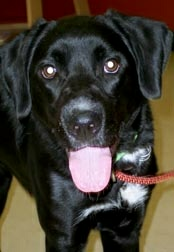

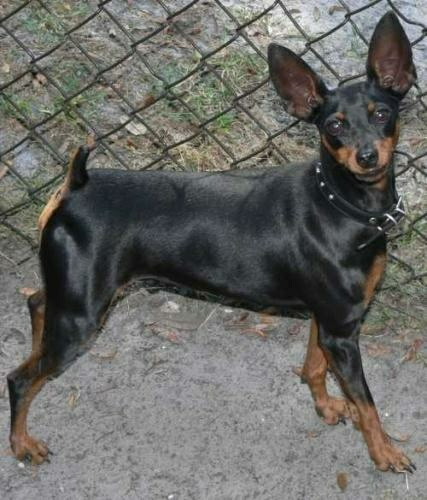

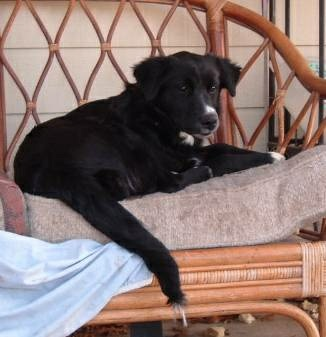

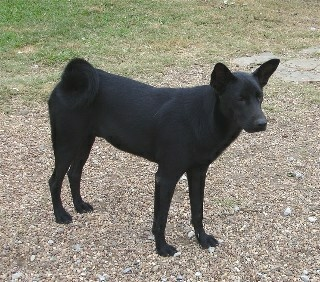

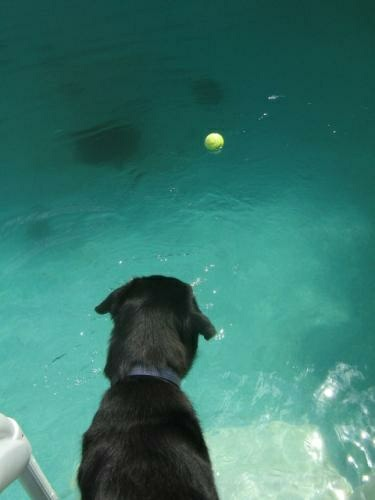

In [20]:
from IPython.display import display
for result in results:
    display(result[indexing_key])

## Create a `Template`

In [21]:
from superduper import Template

template = Template(
    'image-vector-search',
    template=application,
    substitutions={'docs': 'table'},
)

template.export('.')

2024-Aug-23 15:52:17.50| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf dill already exists
2024-Aug-23 15:52:17.50| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf dill already exists
2024-Aug-23 15:52:17.50| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf vector[1024] already exists
2024-Aug-23 15:52:17.83| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf dill already exists
2024-Aug-23 15:52:17.83| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf dill already exists
2024-Aug-23 15:52:17.83| WARNING  | Duncans-MacBook-Pro.local| superduper.base.document:415  | Leaf dill already exists
